In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd


from wordcloud import WordCloud
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional,Dropout

import re 
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from transformers import BertTokenizer, BertConfig,AdamW, BertForSequenceClassification,get_linear_schedule_with_warmup

2022-03-16 02:07:36.324241: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-16 02:07:36.324279: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Intro

This dataset contains sentences which can be referred to different emotions - sadness, anger, love, surprise, fear and joy.

I've tried to do a simple emotion detection by sentence input. 

In the future I'll upload version 2 to try a different way with more complex modules.

# Import data

In [3]:
test_data = pd.read_csv("./test.txt", header=None, sep=";", names=["Comment","Emotion"], encoding="utf-8")
train_data = pd.read_csv("./train.txt", header=None, sep=";", names=["Comment","Emotion"], encoding="utf-8")
validation_data = pd.read_csv("./val.txt", header=None, sep=";", names=["Comment","Emotion"], encoding="utf-8")
print("Train : ", train_data.shape)
print("Test : ", test_data.shape)
print("Validation : ", validation_data.shape)

Train :  (958, 2)
Test :  (985, 2)
Validation :  (1011, 2)


In [4]:
train_data.head()

,Comment,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


I will first try to see if length of the comments is correlated to the emotion

In [5]:
train_data['length'] = [len(x) for x in train_data['Comment']]
train_data.head()

,Comment,Emotion,length
0,i didnt feel humiliated,sadness,23
1,i can go from feeling so hopeless to so damned...,sadness,108
2,im grabbing a minute to post i feel greedy wrong,anger,48
3,i am ever feeling nostalgic about the fireplac...,love,92
4,i am feeling grouchy,anger,20


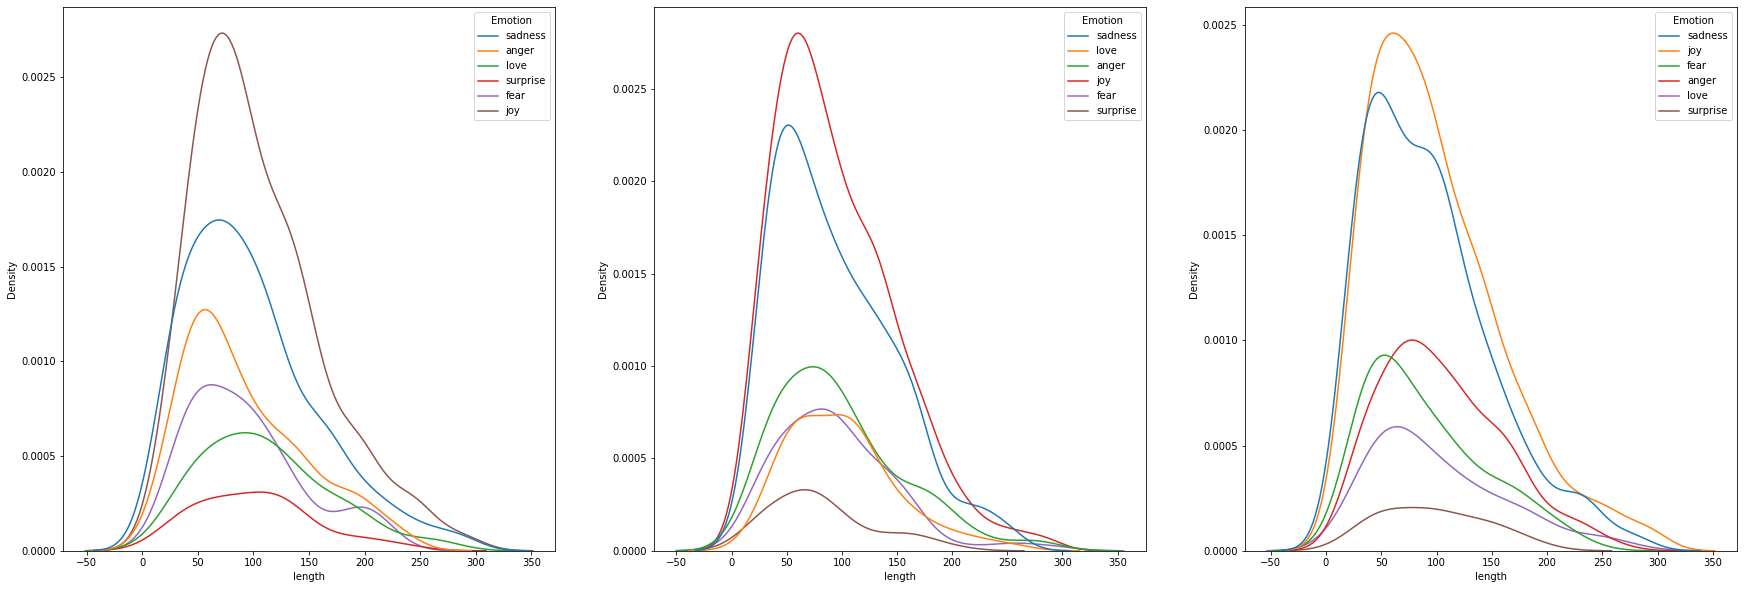

In [6]:
all_data = {'Train Data': train_data, 'Validation Data': validation_data, 'Test Data': test_data}
fig, ax = plt.subplots(1,3, figsize=(30,10))
for i, df in enumerate(all_data.values()):
    df2 = df.copy()
    df2['length'] = [len(x) for x in df2['Comment']]
    sns.kdeplot(data=df2,x='length',hue='Emotion', ax=ax[i])
plt.show()

In [7]:
def words_cloud(wordcloud, df):
    plt.figure(figsize=(10, 10))
    plt.title(df+' Word Cloud', size = 16)
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");

### Words Cloud for each emotion

In [8]:
emotions_list = train_data['Emotion'].unique()
emotions_list

array(['sadness', 'anger', 'love', 'surprise', 'fear', 'joy', nan],
      dtype=object)

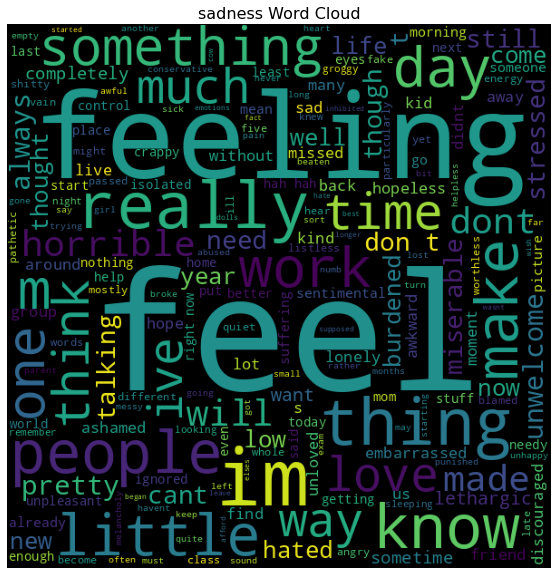

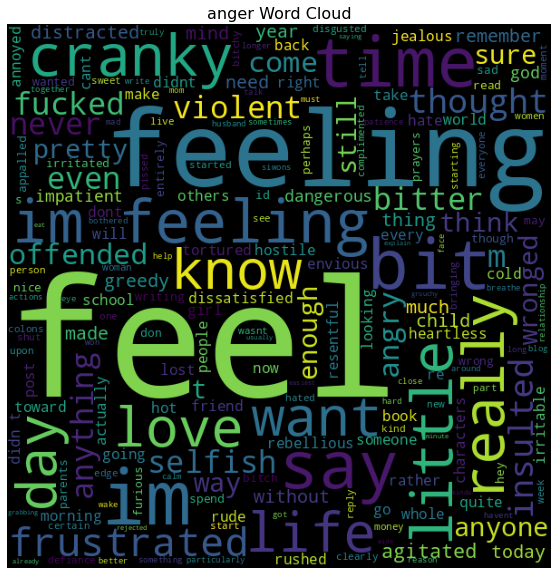

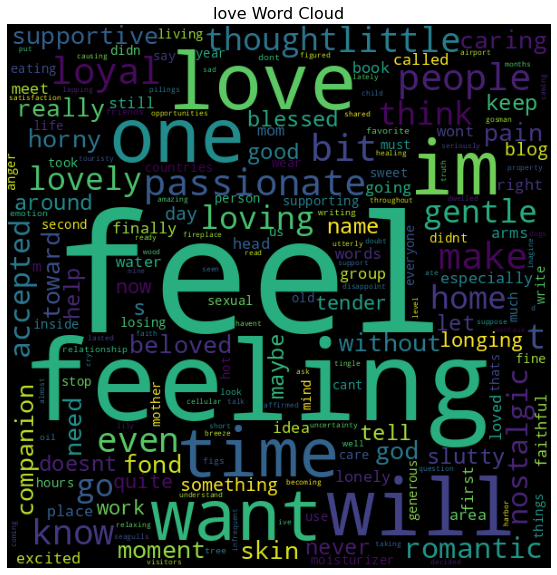

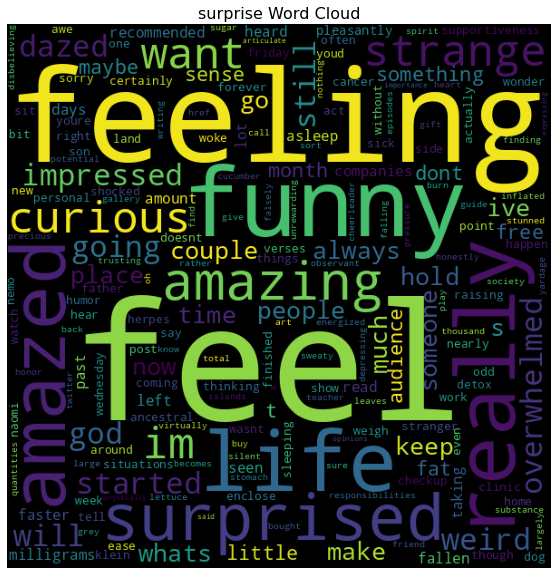

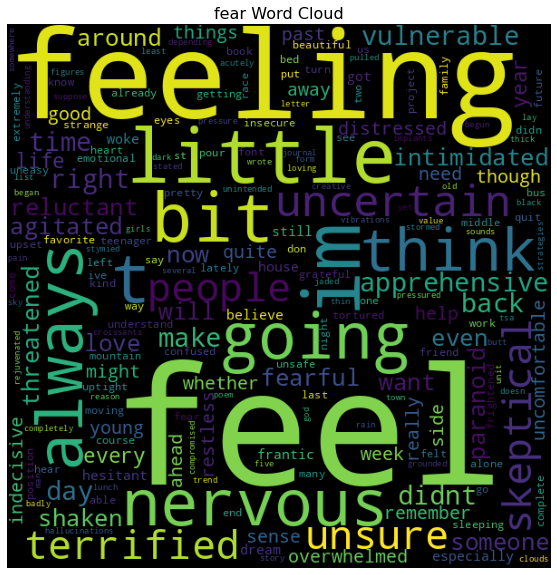

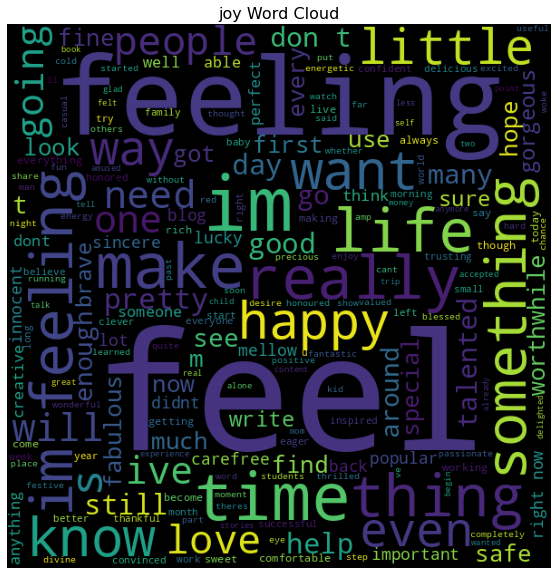

In [9]:
for emotion in emotions_list:
    text = ' '.join([sentence for sentence in train_data.loc[train_data['Emotion'] == emotion,'Comment']])
    try:
        wordcloud = WordCloud(width = 600, height = 600).generate(text)
        words_cloud(wordcloud, emotion)
    except ValueError:
        pass

# Preprocessing

#### Label Encoding

In [10]:
lb = LabelEncoder()
train_data['Emotion'] = lb.fit_transform(train_data['Emotion'])
test_data['Emotion'] = lb.fit_transform(test_data['Emotion'])
validation_data['Emotion'] = lb.fit_transform(validation_data['Emotion'])

In [11]:
train_data.head(2)

,Comment,Emotion,length
0,i didnt feel humiliated,4,23
1,i can go from feeling so hopeless to so damned...,4,108


#### Removing unrelevent stopwords and chars
Text cleaning fuction was inspired by this project - 
https://www.kaggle.com/muratkarakurt/emotion-detect-comment-97/notebook

In [12]:
nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/nick/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
max_len=train_data['length'].max()
max_len

298

In [14]:
vocabSize = 11000

In [15]:
tokenizer = Tokenizer()
x_train = pd.DataFrame({'Column1': x_train[:, 0], 'Column2': x_train[:, 1]})
tokenizer.fit_on_texts(pd.concat(x_train, axis=0))

NameError: name 'x_train' is not defined

In [ ]:
from tensorflow.keras.preprocessing.text import one_hot
def text_cleaning(df, column):
    """Removing unrelevent chars, Stemming and padding"""
    stemmer = PorterStemmer()
    corpus = []
    
    for text in df[column]:
        text = re.sub("[^a-zA-Z]", " ", text)
        text = text.lower()
        text = text.split()
        text = [stemmer.stem(word) for word in text if word not in stopwords]
        text = " ".join(text)
        corpus.append(text)
    one_hot_word = [one_hot(input_text=word, n=vocabSize) for word in corpus]
    pad = pad_sequences(sequences=one_hot_word,maxlen=max_len,padding='pre')
    print(pad.shape)
    return pad

In [ ]:
x_train = text_cleaning(train_data, "Comment")
x_test = text_cleaning(test_data, "Comment")
x_val = text_cleaning(validation_data, "Comment")

(958, 298)
(985, 298)
(1011, 298)


In [ ]:
y_train = train_data["Emotion"]
y_test = test_data["Emotion"]
y_val = validation_data["Emotion"]

In [ ]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

# Model building

After number of tries with higher/lower dim, and adding layers, this model was the most efficient:

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=vocabSize,output_dim=150,input_length=300))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(64,activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(6,activation='softmax'))

In [ ]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

In [ ]:
callback = EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)

In [ ]:
hist = model.fit(x_train,y_train,epochs=10,batch_size=64,
                 validation_data=(x_val,y_val), verbose=1, callbacks=[callback])

In [ ]:
model.evaluate(x_val,y_val,verbose=1)

In [ ]:
model.evaluate(x_test,y_test,verbose=1)

In [ ]:
accuracy = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss=hist.history['loss']
val_loss=hist.history['val_loss']
epochs=range(len(accuracy))

plt.plot(epochs,accuracy,'b', label='Training accuracy')
plt.plot(epochs,val_acc,'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs,loss,'b', label='Training loss')
plt.plot(epochs,val_loss,'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
def sentence_cleaning(sentence):
    """Pre-processing sentence for prediction"""
    stemmer = PorterStemmer()
    corpus = []
    text = re.sub("[^a-zA-Z]", " ", sentence)
    text = text.lower()
    text = text.split()
    text = [stemmer.stem(word) for word in text if word not in stopwords]
    text = " ".join(text)
    corpus.append(text)
    one_hot_word = [one_hot(input_text=word, n=vocabSize) for word in corpus]
    pad = pad_sequences(sequences=one_hot_word,maxlen=max_len,padding='pre')
    return pad

In [ ]:
sentences = [
            "He was speechles when he found out he was accepted to this new job",
            "This is outrageous, how can you talk like that?",
            "I feel like im all alone in this world",
            "He is really sweet and caring"
            ]
for sentence in sentences:
    print(sentence)
    sentence = sentence_cleaning(sentence)
    result = lb.inverse_transform(np.argmax(model.predict(sentence), axis=-1))[0]
    proba =  np.max(model.predict(sentence))
    print(f"{result} : {proba}\n\n")

The model could improve with more playing around with different kind of layers, more complex ones, I assume, but I tried to keep it simple in this project.

Overall not bad results.